<a href="https://colab.research.google.com/github/iam-abbas/Live-Face-Blur/blob/master/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/iam-abbas/Live-Face-Blur.git

Cloning into 'Live-Face-Blur'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 0), reused 13 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import load_model

from PIL import Image
from scipy import spatial
import matplotlib.pyplot as plt
import numpy as np

import cv2
from google.colab.patches import cv2_imshow

In [3]:
# import tensorflow as tf
# import json
# json_file = open('facenet_model.json')
# json_model = json_file.read()
# model = InceptionResNetV1()
model = load_model('Live-Face-Blur/facenet_keras.h5')
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("facenet_keras.tflite", "wb").write(tflite_model)

91163744

In [5]:
interpreter = tf.lite.Interpreter(model_path="facenet_keras.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'input_1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 160, 160,   3], dtype=int32),
  'shape_signature': array([  1, 160, 160,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [6]:
# Test model on random input data.
input_shape = input_details[0]['shape']
# change the following line to feed into your own data.
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print(input_data.shape)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data.shape)
print(input_details)

(1, 160, 160, 3)
(1, 128)
[{'name': 'input_1', 'index': 0, 'shape': array([  1, 160, 160,   3], dtype=int32), 'shape_signature': array([  1, 160, 160,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [0]:
def preprocess_image(image):
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]
    img = cv2.resize(image, (height, width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.linalg.norm(euclidean_distance)
    return euclidean_distance

In [0]:
def tflite_predict(data):
    interpreter.set_tensor(input_details[0]['index'], data)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])
    return prediction

In [9]:
data = preprocess_image(cv2.imread('Live-Face-Blur/Data/1.jpeg'))
model_pred = model.predict(data)
tflite_pred = tflite_predict(data)
loss = np.square(np.subtract(model_pred,tflite_pred)).mean() 
loss

2.3228728e-13

##### That's cool, minimal loss during conversion from keras model to tflite

In [0]:
threshold = 0.4

def verifyFace(img1, img2):

    img1_representation = tflite_predict(preprocess_image((img1)))[0,:]
    img2_representation = tflite_predict(preprocess_image((img2)))[0,:]
    
    img1_representation = l2_normalize(img1_representation)
    img2_representation = l2_normalize(img2_representation)

    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    print(euclidean_distance)

    if euclidean_distance < threshold:
        return True
    else:
        return False

In [0]:
face_cascade_name = "Live-Face-Blur/haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier()
face_cascade.load(face_cascade_name)

def get_face(img):
  image = cv2.imread(img)
  result_image = image.copy()


  grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  grayimg = cv2.equalizeHist(grayimg)

  faces = face_cascade.detectMultiScale(grayimg, 1.1, 5, 0|cv2.CASCADE_SCALE_IMAGE, (20, 20))
  if len(faces) != 0:
    face_array = []
    x_y = []
    for f in faces:
        x, y, w, h = [ v for v in f ]
        sub_face = image[y:y+h, x:x+w]
        # sub_face = cv2.cvtColor(sub_face, cv2.COLOR_BGR2GRAY)
        face_array.append(sub_face)
        x_y.append([x, y])

        
    return face_array, x_y
  else:
    print("No face found.")
    return [image], [0, 0]


In [0]:
def check_face(img):
  count = 0
  faces = []
  x_y = []
  imgs = []
  match = None
  for i in range(1, 6):
    imgs.append('Live-Face-Blur/Data/'+str(i)+'.jpeg')
  im_data, nay =  get_face(img)
  for i in range(len(im_data)):
    cv2_imshow(im_data[i])
    for im in imgs:
      im, no = get_face(im)
      if not verifyFace((im)[0], im_data[i]):
        faces.append(im_data[i])
        x_y.append(nay[i])
      else:
        match = im_data[i]
        print("found")
        count += 1


  return faces, x_y, match


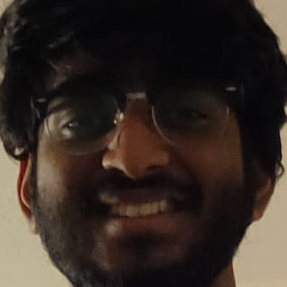

0.38986996
found
0.37563774
found
0.37918174
found
No face found.
0.53653944
0.3565402
found


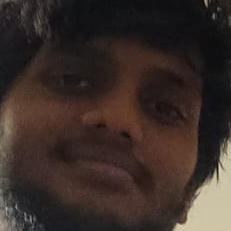

0.6020042
0.6238206
0.6961838
No face found.
0.8502786
0.7037118


In [13]:
faces, x_y, match = check_face('Live-Face-Blur/t.jpeg')

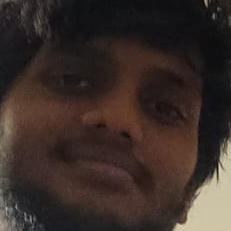

In [14]:
blur = [[], []]
for i in range(len(faces)):
  if np.array_equal(faces[i], match):
    continue
  else:
    blur[0] = faces[i]
    blur[1] = x_y[i]

cv2_imshow(blur[0])

In [15]:
blur[1][1]

191

In [0]:
sub_face = cv2.GaussianBlur(blur[0],(53, 53), 70)

In [0]:
image = cv2.imread('Live-Face-Blur/t.jpeg')
result_image = image.copy()
result_image[blur[1][1]:blur[1][1]+sub_face.shape[0], blur[1][0]:blur[1][0]+sub_face.shape[1]] = sub_face

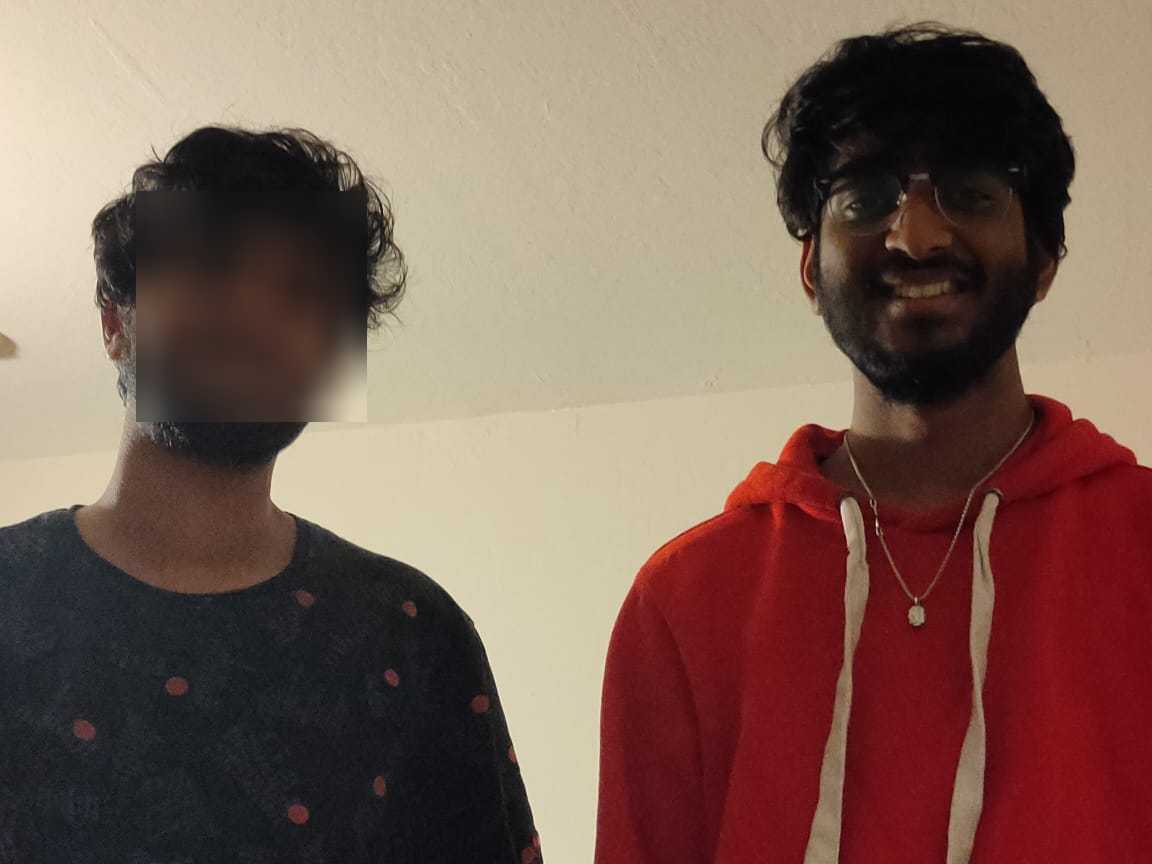

In [19]:
cv2_imshow(result_image)